## Cohere

This notebook demonstrates how to use Cohere Embeddings with Chroma.

If you have not already, [create a Cohere account](https://dashboard.cohere.ai/welcome/register) and get your API Key.

First a basic example:

In [1]:
! pip install chromadb --quiet
! pip install cohere --quiet
! pip install Pillow --quiet
! pip install datasets --quiet
! pip install matplotlib --quiet

In [2]:
import os
import getpass

os.environ["CHROMA_COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [3]:
import chromadb
from chromadb.utils import embedding_functions

cohere_ef = embedding_functions.CohereEmbeddingFunction(api_key=os.environ["CHROMA_COHERE_API_KEY"],  model_name="large")

client = chromadb.Client()
collection = client.create_collection("cohere_python", embedding_function=cohere_ef)

collection.add(
    ids=["1", "2", "3"],
    documents=["I like apples", "I like bananas", "I like oranges"],
    metadatas=[{"fruit": "apple"}, {"fruit": "banana"}, {"fruit": "orange"}],
)

print(collection.query(query_texts=["citrus"], n_results=1))


{'ids': [['3']], 'embeddings': None, 'documents': [['I like oranges']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[{'fruit': 'orange'}]], 'distances': [[6728.8798828125]]}


## Multilingual Example

Cohere can support many languages! In this example we store text in many languages, and then query in English.

In [4]:
cohere_mutlilingual = embedding_functions.CohereEmbeddingFunction(
        api_key=os.environ["CHROMA_COHERE_API_KEY"], 
        model_name="multilingual-22-12")

# 나는 오렌지를 좋아한다 is "I like oranges" in Korean
multilingual_texts = [ 'Hello from Cohere!', 'مرحبًا من كوهير!', 
        'Hallo von Cohere!', 'Bonjour de Cohere!', 
        '¡Hola desde Cohere!', 'Olá do Cohere!', 
        'Ciao da Cohere!', '您好，来自 Cohere！',
        'कोहेरे से नमस्ते!', '나는 오렌지를 좋아한다'  ]

collection = client.create_collection("cohere_multilingual", embedding_function=cohere_mutlilingual)

collection.add(
    ids=[str(i) for i in range(len(multilingual_texts))],
    documents=multilingual_texts
)

print(collection.query(query_texts=["citrus"], n_results=1))


{'ids': [['9']], 'embeddings': None, 'documents': [['나는 오렌지를 좋아한다']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[None]], 'distances': [[30.732187271118164]]}


## Multimodal Example

Cohere now supports images! In this example we store images in many languages, and then query in text.

/Users/jairadhakrishnan/github.com/chroma-core/chroma/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


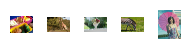

In [5]:
import os
from datasets import load_dataset, Image
from matplotlib import pyplot as plt


dataset = load_dataset(path="detection-datasets/coco", split="train", streaming=True)

IMAGE_FOLDER = "images"
N_IMAGES = 5

# For plotting
plot_cols = 5
plot_rows = N_IMAGES // plot_cols
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(plot_rows*2, plot_cols*2))
axes = axes.flatten()

# Write the images to a folder
dataset_iter = iter(dataset)
os.makedirs(IMAGE_FOLDER, exist_ok=True)
for i in range(N_IMAGES):
    image = next(dataset_iter)['image']
    axes[i].imshow(image)
    axes[i].axis("off")

    image.save(f"images/{i}.jpg")

plt.tight_layout()
plt.show()

Adding image 0: images/0.jpg
Adding image 1: images/1.jpg
Adding image 2: images/2.jpg
Adding image 3: images/3.jpg
Adding image 4: images/4.jpg


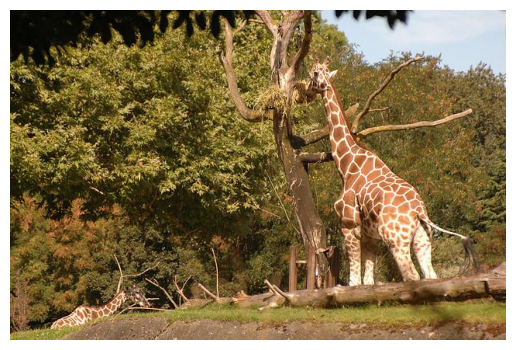

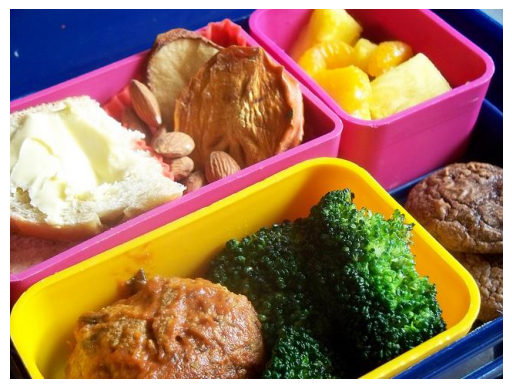

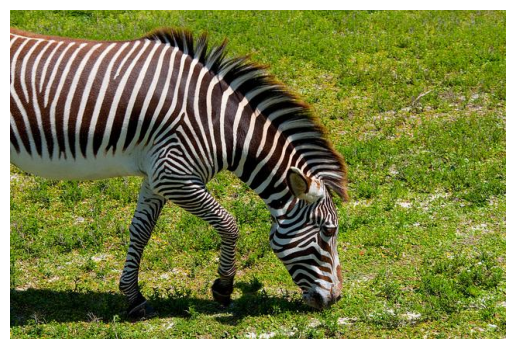

In [6]:
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import CohereEmbeddingFunction

multimodal_cohere_ef = CohereEmbeddingFunction(
    model_name="embed-english-v3.0",
)
image_loader = ImageLoader()

multimodal_collection = client.create_collection(
    name="multimodal", 
    embedding_function=multimodal_cohere_ef, 
    data_loader=image_loader)

# Get the uris to the images
image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER)])
ids = [str(i) for i in range(len(image_uris))]
for i in range(len(image_uris)):
    print(f"Adding image {i}: {image_uris[i]}")
    # max images per add is 1, see cohere docs https://docs.cohere.com/v2/reference/embed#request.body.images
    multimodal_collection.add(ids=[str(i)], uris=[image_uris[i]])

retrieved = multimodal_collection.query(query_texts=["animals"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()